All libraries imported successfully!
Loaded and processed JPEG image shape: (500, 500)
Binary image (risk_map) shape: (500, 500)
JPEG satellite image processed successfully for ML features and visualization!


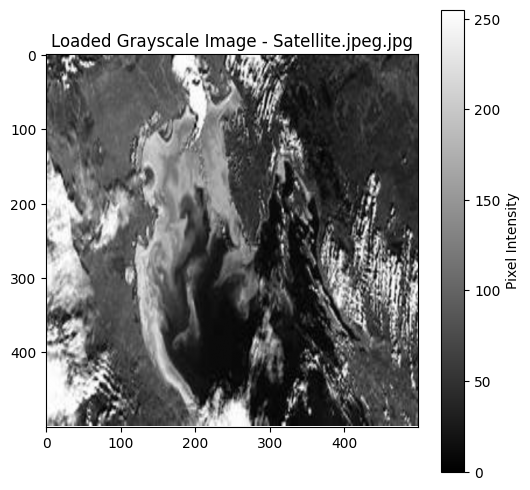

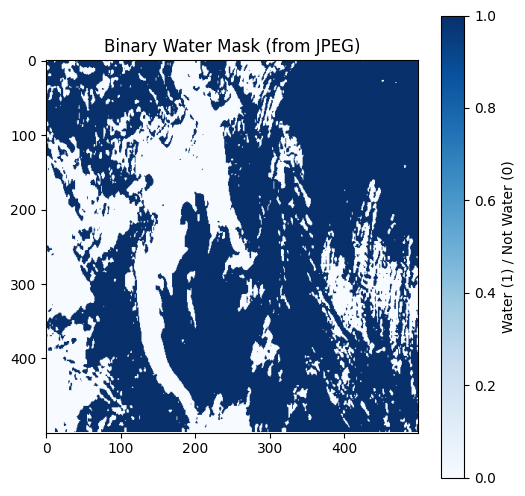


Raw Environmental Data Loaded:
   Latitude  Longitude  Water_Level (cm)  Rainfall (mm)  NDWI  \
0   17.3850    78.4867               130             95   0.7   
1   16.5062    80.6480                85             40   0.3   
2   15.3173    75.7139               120            110   0.6   
3   18.1124    79.0193               140            130   0.8   
4   19.7515    75.7139                70             20   0.2   

   Temperature (°C)  Humidity (%) Flood_Risk  
0              28.5            85       High  
1              31.0            60        Low  
2              29.2            78     Medium  
3              27.8            88       High  
4              34.5            45    No Risk  

Latest Rainfall (from last record): 20 mm
Latest Temperature (from last record): 34.5 °C
Location of Latest Environmental Data: Latitude=19.7515, Longitude=75.7139

Merged DataFrame shape: (5, 250008)
Image data merged with environmental data.
Flood_Risk classes: ['High' 'Low' 'Medium' 'No Ris

C:\Users\Navya Gopika\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Navya Gopika\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Navya Gopika\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behav


✅ Model and Scaler saved successfully as 'flood_risk_model.pkl' and 'flood_scaler.pkl'.


In [10]:
# --- Cell 1: Combined Machine Learning Pipeline & Data Preparation for DisasterWatch AI ---

# --- 0. Import all necessary libraries ---
import numpy as np # Fundamental package for numerical operations
import pandas as pd # Powerful library for data manipulation
import matplotlib.pyplot as plt # For creating static plots and visualizations
import folium # For creating interactive web maps
from PIL import Image # Python Imaging Library for image processing
import io # Standard Python library for handling input/output operations
import base64 # For encoding images to base64 for web embedding
import datetime # For generating timestamps

# OpenCV for image processing (install with: pip install opencv-python)
import cv2

# Scikit-learn for Machine Learning (install with: pip install scikit-learn)
from sklearn.model_selection import train_test_split # For splitting data
from sklearn.preprocessing import LabelEncoder, StandardScaler # For encoding labels and scaling features
from sklearn.ensemble import RandomForestClassifier # Our chosen ML model
from sklearn.metrics import classification_report # For evaluating the model

import joblib # For saving and loading trained models (install with: pip install joblib)

print("All libraries imported successfully!")

# --- 1. Load and Process Satellite Image (JPEG) ---
# IMPORTANT: Confirm the path to your Satellite.jpeg.jpg file.
# Ensure 'Satellite.jpeg.jpg' is in the same directory as this notebook.
satellite_image_path = "Satellite.jpeg.jpg"

try:
    # Load the image in grayscale using OpenCV
    img_cv2 = cv2.imread(satellite_image_path, cv2.IMREAD_GRAYSCALE)
    if img_cv2 is None: # Check if image loaded successfully
        raise FileNotFoundError(f"Image file not found or could not be loaded: {satellite_image_path}")

    # Resize the image to a consistent dimension (e.g., 500x500 pixels)
    # This ensures consistency for the risk_map overlay and ML features.
    img_resized = cv2.resize(img_cv2, (500, 500))

    # Convert to binary: Pixels darker than threshold -> 1 (water-like), else 0.
    # THRESH_BINARY_INV means pixels below 100 become 1 (white), others 0 (black).
    # This effectively makes dark areas (water) stand out as '1'.
    # Adjust '100' if needed based on how water appears in your specific JPEG.
    _, binary_img = cv2.threshold(img_resized, 100, 1, cv2.THRESH_BINARY_INV)

    # `grayscale_band` is used for the initial grayscale visualization.
    grayscale_band = img_resized.astype(np.float32)

    # `risk_map` will be used for the image overlay on the Folium map.
    # It directly represents the 'water-like' areas detected from the JPEG.
    risk_map = binary_img.astype(np.uint8) # Ensure it's uint8 for image display

    # `flat_binary` is the flattened version of the binary image, used as features for the ML model.
    flat_binary = binary_img.flatten()

    # For JPEG, georeferencing (transform, crs) is not available, so set to None.
    transform = None
    crs = None

    print(f"Loaded and processed JPEG image shape: {grayscale_band.shape}")
    print(f"Binary image (risk_map) shape: {risk_map.shape}")
    print("JPEG satellite image processed successfully for ML features and visualization!")

    # Visualize the processed grayscale image
    plt.figure(figsize=(6, 6))
    plt.imshow(grayscale_band, cmap='gray')
    plt.title(f'Loaded Grayscale Image - {satellite_image_path}')
    plt.colorbar(label='Pixel Intensity')
    plt.show()

    # Visualize the binary water mask (risk_map)
    plt.figure(figsize=(6, 6))
    plt.imshow(risk_map, cmap='Blues') # 'Blues' colormap makes '1' (water) appear blue
    plt.title('Binary Water Mask (from JPEG)')
    plt.colorbar(label='Water (1) / Not Water (0)')
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{satellite_image_path}' was not found.")
    print("Please ensure the .jpeg file is in the same folder as this notebook and the filename is correct.")
    print("Proceeding with dummy satellite imagery for ML features and visualization as a fallback.")
    # Fallback to dummy data if real file isn't found
    img_height, img_width = 500, 500
    dummy_nir = np.random.rand(img_height, img_width).astype(np.float32) * 4000 + 1000
    center_y, center_x, radius = img_height // 2, img_width // 2, 100
    for i in range(img_height):
        for j in range(img_width):
            distance = np.sqrt((i - center_x)**2 + (j - center_y)**2)
            if distance < radius:
                dummy_nir[i, j] = np.random.rand() * 500 + 100
    
    grayscale_band = dummy_nir # Use dummy NIR as grayscale_band
    risk_map = (dummy_nir < 1000).astype(np.uint8) # Simple dummy water mask
    flat_binary = risk_map.flatten() # Flatten the dummy risk_map for ML feature creation
    transform = None
    crs = None
    print("Dummy satellite imagery generated instead.")


# --- 2. Load Environmental Data (Latitude.csv) ---
# IMPORTANT: Confirm the path to your Latitude.csv file.
# Ensure 'Latitude.csv' is in the same directory as this notebook.
environmental_data_path = 'Latitude.csv'

try:
    # Assign to env_data directly in the try block
    env_data = pd.read_csv(environmental_data_path)
    print("\nRaw Environmental Data Loaded:")
    print(env_data.head())

    # Extract latest environmental data for dashboard display and alert logic
    latest_cumulative_rainfall = env_data['Rainfall (mm)'].iloc[-1]
    latest_temperature = env_data['Temperature (°C)'].iloc[-1]
    latest_env_lat = env_data['Latitude'].iloc[-1]
    latest_env_lon = env_data['Longitude'].iloc[-1]
    print(f"\nLatest Rainfall (from last record): {latest_cumulative_rainfall} mm")
    print(f"Latest Temperature (from last record): {latest_temperature} °C")
    print(f"Location of Latest Environmental Data: Latitude={latest_env_lat}, Longitude={latest_env_lon}")

except FileNotFoundError:
    print(f"Error: The file '{environmental_data_path}' was not found.")
    print("Please ensure the .csv file is in the same folder as this notebook and the filename is correct.")
    print("Proceeding with dummy environmental data for ML and dashboard as a fallback.")
    # Fallback to dummy environmental data, assigning to env_data
    env_data = pd.DataFrame({
        'Latitude': np.linspace(16.0, 17.0, 5),
        'Longitude': np.linspace(80.0, 81.0, 5),
        'Rainfall (mm)': [5, 20, 80, 120, 60],
        'Temperature (°C)': [28, 26, 25, 24, 27],
        'Water_Level (cm)': [50, 70, 100, 130, 80],
        'Humidity (%)': [60, 70, 80, 85, 75],
        'Flood_Risk': ['Low', 'Medium', 'High', 'High', 'Medium']
    })
    latest_cumulative_rainfall = env_data['Rainfall (mm)'].iloc[-1]
    latest_temperature = env_data['Temperature (°C)'].iloc[-1]
    latest_env_lat = env_data['Latitude'].iloc[-1]
    latest_env_lon = env_data['Longitude'].iloc[-1]
    print("Dummy environmental data generated instead.")


# --- 3. Merge Image Data (Features) with Environmental Data ---
# The image data (flat_binary) needs to be associated with each row of the environmental data.
# We tile the flattened binary image to match the number of rows in the environmental DataFrame.
repeated_pixels = np.tile(flat_binary, (len(env_data), 1)) # Use env_data here
pixel_df = pd.DataFrame(repeated_pixels, columns=[f"px_{i}" for i in range(len(flat_binary))])
merged_df = pd.concat([env_data.reset_index(drop=True), pixel_df], axis=1) # Use env_data here
print(f"\nMerged DataFrame shape: {merged_df.shape}")
print("Image data merged with environmental data.")

# --- 4. Encode Target Labels ('Flood_Risk') ---
le = LabelEncoder()
merged_df['Flood_Risk_Encoded'] = le.fit_transform(merged_df['Flood_Risk'])
print(f"Flood_Risk classes: {le.classes_}")
print("Flood_Risk labels encoded.")

# --- 5. Split Features (X) and Target (y) ---
# Features include all columns except the original 'Flood_Risk' and the new 'Flood_Risk_Encoded'
X = merged_df.drop(['Flood_Risk', 'Flood_Risk_Encoded', 'Latitude', 'Longitude'], axis=1)
y = merged_df['Flood_Risk_Encoded']
print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# --- 6. Normalize Features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features scaled.")

# --- 7. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"Train-test split: X_train={X_train.shape}, X_test={X_test.shape}")

# --- 8. Train Classifier (RandomForestClassifier) ---
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("\nRandomForestClassifier trained successfully.")

# --- 9. Predict and Evaluate ---
y_pred = clf.predict(X_test)
print("\nClassification Report (Model Performance):\n")
# FIX: Explicitly provide all possible labels to classification_report
# This ensures it can generate a report for all classes, even if some are missing in y_test.
print(classification_report(y_test, y_pred, target_names=le.classes_,
                            labels=np.arange(len(le.classes_)), zero_division='warn'))

# --- 10. Optional: Save the Trained Model and Scaler ---
joblib.dump(clf, "flood_risk_model.pkl")
joblib.dump(scaler, "flood_scaler.pkl")
print("\n✅ Model and Scaler saved successfully as 'flood_risk_model.pkl' and 'flood_scaler.pkl'.")

# --- Define `ndwi` (alias for `risk_map`) and `rainfall_event_threshold` for consistency with later cells ---
# `ndwi` is used in the alert logic and map overlay, now representing our image-derived water mask.
ndwi = risk_map
# This threshold is used in the alert banner logic, not directly in the ML model.
# Adjust this based on your understanding of what constitutes high rainfall.
rainfall_event_threshold = 15 # millimeters


In [11]:
# --- Cell 2: Interactive Map Generation ---

# Define the approximate geographical bounds of India for the map view.
india_bounds = [
    [6.0, 68.0],  # Southernmost point (approx. near Nicobar) and Westernmost
    [37.0, 98.0]  # Northernmost point (approx. near Kashmir) and Easternmost
]

# Create a Folium map object, set to fit India and with interactive controls disabled.
m = folium.Map(
    tiles='OpenStreetMap',
    zoom_control=False,
    scrollWheelZoom=False,
    doubleClickZoom=False,
    dragging=False,
    attribution_control=False
)
m.fit_bounds(india_bounds) # Automatically adjust zoom to show all of India

# Plot Red/Green Dots from the 'Latitude.csv' dataset (env_data)
# Iterate through each row of your environmental data DataFrame.
for index, row in env_data.iterrows():
    point_lat = row['Latitude']
    point_lon = row['Longitude']
    # Convert Flood_Risk status to lowercase for robust comparison
    flood_risk_status = str(row['Flood_Risk']).lower()

    # Plot red dots for high/medium/yes flood risk, green for others.
    if 'high' in flood_risk_status or 'medium' in flood_risk_status or 'yes' in flood_risk_status:
        folium.CircleMarker(
            location=[point_lat, point_lon],
            radius=8, # Increased radius for red points
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            popup=f"<b>Flood Risk: {row['Flood_Risk']}</b><br>"
                  f"Rainfall: {row['Rainfall (mm)']} mm<br>"
                  f"Temperature: {row['Temperature (°C)']} °C<br>"
                  f"Water Level: {row['Water_Level (cm)']} cm"
        ).add_to(m)
    else:
        folium.CircleMarker(
            location=[point_lat, point_lon],
            radius=3,
            color='green',
            fill=True,
            fill_color='green',
            fill_opacity=0.5,
            popup=f"<b>Flood Risk: {row['Flood_Risk']}</b><br>"
                  f"Rainfall: {row['Rainfall (mm)']} mm<br>"
                  f"Temperature: {row['Temperature (°C)']} °C<br>"
                  f"Water Level: {row['Water_Level (cm)']} cm"
        ).add_to(m)

# Add the Satellite Image Risk Map as an Overlay (from Cell 1's risk_map)
# Convert the NumPy risk_map into a base64 encoded PNG for web display.
risk_map_display = (risk_map * 255).astype(np.uint8)
img_pil_risk = Image.fromarray(risk_map_display, mode='L')
file_stream = io.BytesIO()
img_pil_risk.save(file_stream, format='PNG')
encoded_image = base64.b64encode(file_stream.getvalue()).decode('utf-8')
image_data_uri = f"data:image/png;base64,{encoded_image}"

# Define bounds for the image overlay around the last environmental data point.
lat_offset = 0.05
lon_offset = 0.05
bounds = [
    [latest_env_lat - lat_offset, latest_env_lon - lon_offset], # South-West corner
    [latest_env_lat + lat_offset, latest_env_lon + lon_offset]  # North-East corner
]

# Add the risk map as an image overlay on the Folium map.
folium.raster_layers.ImageOverlay(
    image=image_data_uri,
    bounds=bounds,
    opacity=0.6, # Make it quite transparent so base map and dots are visible
    caption='Satellite Image Flood Risk (JPEG Analysis)'
).add_to(m)

# Add a LayerControl to the map for toggling layers.
folium.LayerControl().add_to(m)

# Get the HTML representation of the Folium map object.
map_html = m._repr_html_()

print("Interactive map generated successfully!")


Interactive map generated successfully!


In [12]:
# --- Cell 2: Interactive Map Generation ---

# Define the approximate geographical bounds of India for the map view.
india_bounds = [
    [6.0, 68.0],  # Southernmost point (approx. near Nicobar) and Westernmost
    [37.0, 98.0]  # Northernmost point (approx. near Kashmir) and Easternmost
]

# Create a Folium map object, set to fit India and with interactive controls disabled.
m = folium.Map(
    tiles='OpenStreetMap',
    zoom_control=False,
    scrollWheelZoom=False,
    doubleClickZoom=False,
    dragging=False,
    attribution_control=False
)
m.fit_bounds(india_bounds) # Automatically adjust zoom to show all of India

# Plot Red/Green Dots from the 'Latitude.csv' dataset (env_data)
# Iterate through each row of your environmental data DataFrame.
for index, row in env_data.iterrows():
    point_lat = row['Latitude']
    point_lon = row['Longitude']
    # Convert Flood_Risk status to lowercase for robust comparison
    flood_risk_status = str(row['Flood_Risk']).lower()

    # Plot red dots for high/medium/yes flood risk, green for others.
    if 'high' in flood_risk_status or 'medium' in flood_risk_status or 'yes' in flood_risk_status:
        folium.CircleMarker(
            location=[point_lat, point_lon],
            radius=5,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            popup=f"<b>Flood Risk: {row['Flood_Risk']}</b><br>"
                  f"Rainfall: {row['Rainfall (mm)']} mm<br>"
                  f"Temperature: {row['Temperature (°C)']} °C<br>"
                  f"Water Level: {row['Water_Level (cm)']} cm"
        ).add_to(m)
    else:
        folium.CircleMarker(
            location=[point_lat, point_lon],
            radius=3,
            color='green',
            fill=True,
            fill_color='green',
            fill_opacity=0.5,
            popup=f"<b>Flood Risk: {row['Flood_Risk']}</b><br>"
                  f"Rainfall: {row['Rainfall (mm)']} mm<br>"
                  f"Temperature: {row['Temperature (°C)']} °C<br>"
                  f"Water Level: {row['Water_Level (cm)']} cm"
        ).add_to(m)

# Add the Satellite Image Risk Map as an Overlay (from Cell 1's risk_map)
# Convert the NumPy risk_map into a base64 encoded PNG for web display.
risk_map_display = (risk_map * 255).astype(np.uint8)
img_pil_risk = Image.fromarray(risk_map_display, mode='L')
file_stream = io.BytesIO()
img_pil_risk.save(file_stream, format='PNG')
encoded_image = base64.b64encode(file_stream.getvalue()).decode('utf-8')
image_data_uri = f"data:image/png;base64,{encoded_image}"

# Define bounds for the image overlay around the last environmental data point.
# Adjust these offsets to control the size of the JPEG overlay on the map.
lat_offset = 0.05 # UNCOMMENTED: Adjust this to make the image appear larger or smaller on the map
lon_offset = 0.05 # UNCOMMENTED: Adjust this to make the image appear larger or smaller on the map
bounds = [
    [latest_env_lat - lat_offset, latest_env_lon - lon_offset], # South-West corner
    [latest_env_lat + lat_offset, latest_env_lon + lon_offset]  # North-East corner
]

# Add the risk map as an image overlay on the Folium map.
folium.raster_layers.ImageOverlay(
    image=image_data_uri,
    bounds=bounds,
    opacity=0.6, # Make it quite transparent so base map and dots are visible
    caption='Satellite Image Flood Risk (JPEG Analysis)'
).add_to(m)

# Add a LayerControl to the map for toggling layers.
folium.LayerControl().add_to(m)

# Get the HTML representation of the Folium map object.
map_html = m._repr_html_()

print("Interactive map generated successfully!")


Interactive map generated successfully!
